In [2]:
import random
import sys
import torch
import time
from diffusers import DiffusionPipeline

In [3]:
device = "cuda"
use_refiner = False
seed = random.randint(0, sys.maxsize)
n_steps = 40
high_noise_frac = 0.8

In [4]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


In [5]:
if use_refiner:
    refiner = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-refiner-1.0",
        text_encoder_2=pipe.text_encoder_2,
        vae=pipe.vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
    )

    refiner = refiner.to(device)
    pipe.enable_model_cpu_offload()
    pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
else:
    #pipe = pipe.to(device)
    pipe.enable_model_cpu_offload()

In [6]:
prompt = "illustration, pokemon card, HD, ultra quality, masterpiece, realistic, vibrant colors, high resolution, trending on ArtStation, ((watercolor), charizard, (flying, fire-breathing dragon), intense battle), lens: Macro, (dramatic lighting, vivid colors), fully evolved, legendary Negative prompt: (bad art, beginner, amateur, poorly drawn, low contrast, out of frame, ugly, text, poorly drawn hands, poorly drawn feet, poorly drawn face, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low quality)"

In [7]:
images = pipe(
    prompt=prompt,
    num_images_per_prompt=1,
    output_type="latent" if use_refiner else "pil"
).images

Token indices sequence length is longer than the specified maximum sequence length for this model (122 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['out of frame, ugly, text, poorly drawn hands, poorly drawn feet, poorly drawn face, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low quality )']
Token indices sequence length is longer than the specified maximum sequence length for this model (122 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['out of frame, ugly, text, poorly drawn hands, poorly drawn feet, poorly drawn face, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low quality )']
100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


In [8]:
images

[<PIL.Image.Image image mode=RGB size=1024x1024>]

In [9]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
images[0].save(f"pokemon_cards/cards_{timestamp}.png")

In [10]:
if use_refiner:
    images = refiner(
        prompt=prompt,
        num_inference_steps=n_steps,
        denoising_start=high_noise_frac,
        image=images,
    ).images

In [11]:
images

[<PIL.Image.Image image mode=RGB size=1024x1024>]

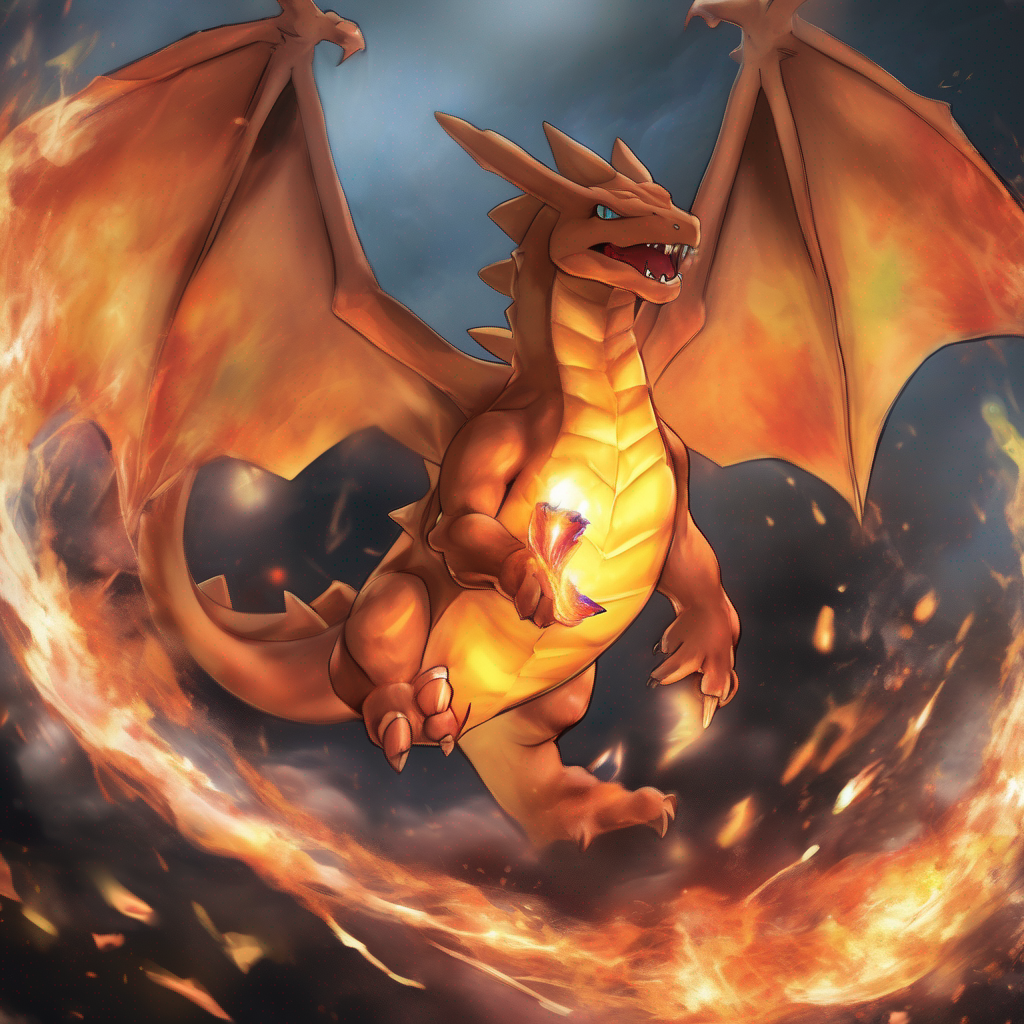

In [12]:
images[0]